# Insuline simulator

The goal of this project is to improve the quality of life for individuals with type 1 diabetes. We focus on simulating food and carbohydrate intake to automatically deliver the appropriate insulin dose when needed, ensuring that glucose levels are consistently kept within a healthy range.
### System Methodology

To train our RL agent safely and efficiently, we have constructed a digital simulation environment using the `simglucose` library, a validated simulator that models the complex dynamics of glucose in the human body. The key to our system is a "wrapper" class that adapts this simulation to the standardized interface of `gymnasium`, the industry standard for RL environments.

This environment defines the "playground" for our AI and is composed of the following elements:

1.  **Environment Construction**: Upon starting a simulation, the system configures a complete virtual scenario. A virtual patient is selected from a set of predefined profiles, each with its own physiological parameters. Next, the simulated devices are initialized: a Continuous Glucose Monitor (CGM), which acts as the agent's "eyes," and an insulin pump, which serves as its "hands." Finally, a meal scenario is introduced to simulate carbohydrate intake.

2.  **Interaction and Learning**: The training occurs in discrete 15-minute cycles. In each step:
    * The agent **observes** the current glucose level, $G(t)$.
    * Based on this observation, it decides on an **action**: the insulin dose to be administered.
    * The environment receives this action, the simulation advances by 15 minutes, and `simglucose` calculates the new glucose level, $G(t+15)$, accounting for both the injected insulin and the effect of meals.
    * The agent receives a **reward**: a positive score is awarded for maintaining glucose within the target range, while states of hypoglycemia and hyperglycemia are heavily penalized.

Through thousands of these "trial-and-error" cycles, the agent learns to associate specific glucose levels with optimal insulin doses, with the ultimate goal of maximizing its cumulative reward and, therefore, maintaining the virtual patient's glycemic stability. This project represents a step towards more intelligent, dynamic, and personalized diabetes control systems.

### Why simglucose?

This is the main engine of the simulation. It provides the mathematical models for:

* **T1DPatient:** Simulates the physiology of a patient with type 1 diabetes (how their body reacts to insulin, carbohydrates, etc.).
* **CGMSensor:** Simulates a Continuous Glucose Monitor (CGM), which measures the patient's glucose level.
* **InsulinPump:** Simulates an insulin pump, the device that administers insulin.
* **RandomScenario:** Creates random scenarios (meals at unexpected times) to make the simulation more realistic.


In [1]:
!pip install matplotlib numpy simglucose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 30.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.9.4-py3-none-any.whl size=215456 sha256=e1c4f5f50df475f7adaba85100ca375ce070b1d37a232d6e6972e87c9287983d
  Stored in directory: /root/.cache/pip/wheels/58/15/94/ba557fc2d79dc47517afe5718a773590e1dd90ec74ccd3d38a
Successfully built gym
  Attempting uninstall: gymnasium
    Found exi

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from simglucose.envs.simglucose_gym_env import T1DSimEnv
from simglucose.simulation.scenario import Scenario

In [3]:
def discretize_glucose(glucose, glucose_velocity, bins=[70, 120, 180]):
    # Bins: <70, 70-120, 120-180, >180
    if glucose < 70:
        glucose_level = 0
    elif glucose < 120:
        glucose_level = 1
    elif glucose < 180:
        glucose_level = 2
    else:
        glucose_level = 3

    if glucose_velocity < -5: # fast down
        velocity_level = 0
    elif glucose_velocity > 5: # fast up
        velocity_level = 2
    else:
        velocity_level = 1


    return glucose_level * 3 + velocity_level

In [4]:
action_space = np.arange(0, 3.5, 0.5) # e.g. 0, 0.5, ..., 6
n_actions = len(action_space)
n_states = 12 # 4 level of glucose * 3 levels of velocity

In [5]:
def reward_fn(glucose):
    mu = 115
    sigma = 25
    reward = np.exp(-0.5 * ((glucose - mu) / sigma) ** 2)
    if glucose < 70:
        reward -= 2.0
    return reward

In [6]:
class TDControlAgent:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.1, alg="qlearning"):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Qvalues = np.zeros((n_states, n_actions))
        self.alg = alg # "sarsa" or "qlearning"

    def get_action_epsilon_greedy(self, s, eps):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        else:
            best_value = np.max(self.Qvalues[s])
            best_actions = (self.Qvalues[s] == best_value)
            prob_actions = best_actions / np.sum(best_actions)
            return np.random.choice(self.n_actions, p=prob_actions)

    def single_step_update(self, s, a, r, new_s, new_a=None, done=False):
        if self.alg == "sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * self.Qvalues[new_s, new_a] - self.Qvalues[s, a]
        elif self.alg == "qlearning":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * np.max(self.Qvalues[new_s]) - self.Qvalues[s, a]
        else:
            raise ValueError("Unknown algorithm")
        self.Qvalues[s, a] += self.lr * deltaQ

In [7]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="qlearning") # or "sarsa"
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

In [8]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    # Initialize velocity and state
    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)

    done = False
    while not done:
        # Agent takes an action
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        # Extract next glucose reading
        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        # Calculate velocity
        glucose_velocity = next_glucose - glucose

        # Get reward and new state
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # --- COMBINED UPDATE AND DECISION LOGIC ---

        # 1. Agent updates its knowledge
        agent.single_step_update(s, a, r, new_s, done=done)

        # 2. Decide the next action with the FORCED WAIT rule
        if action_space[a] > 0:
            a_next = 0  # If we just injected, the next action is 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)

        # 3. Final safety rule
        glucose_level = new_s // 3
        if glucose_level < 2: # If glucose is < 120 mg/dL
            a_next = 0

        # 4. Update variables for the next loop iteration
        glucose = next_glucose
        s = new_s
        a = a_next

    # Print progress every 500 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nAdvanced training complete.")

Episode 500/5000 completed.
Episode 1000/5000 completed.
Episode 1500/5000 completed.
Episode 2000/5000 completed.
Episode 2500/5000 completed.
Episode 3000/5000 completed.
Episode 3500/5000 completed.
Episode 4000/5000 completed.
Episode 4500/5000 completed.
Episode 5000/5000 completed.

Advanced training complete.


In [19]:
np.save('q_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q_table.npy'!")

Model (Table Q) saved correctly in 'q_table.npy'!


Scenario of meals generated:
{'time': [np.float64(318.0), np.float64(727.0), np.float64(1166.0)], 'amount': [21, 72, 76]}


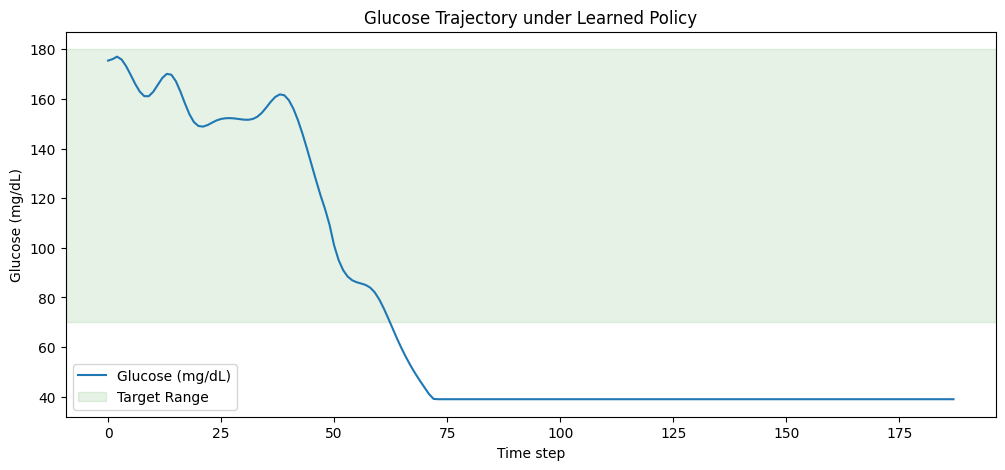

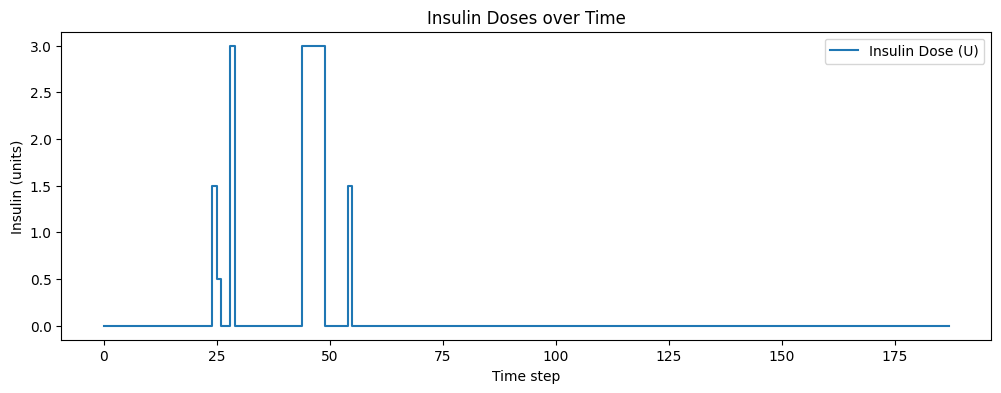

In [202]:
import matplotlib.pyplot as plt

agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if s < 2:
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()